In [1]:
import pathlib
import tensorflow as tf
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt 
# import cv2
import numpy as np

In [2]:
img_height = 224
img_width = 224
input_shape = (img_width, img_height, 3)
batch_size = 32
train_dir = pathlib.Path('../input/cacao-augmented-224/training_img/training_img/')
test_dir  = pathlib.Path('../input/cacao-augmented-224/testing_img/testing_img/')
checkpoint_dir = pathlib.Path('./cacao_CAE/checkpoint')
model_dir = pathlib.Path('./cacao_CAE/model.h5')


In [3]:
train_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  labels=None,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)


Found 13272 files belonging to 1 classes.


2022-04-10 12:54:55.165382: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 12:54:55.251993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 12:54:55.252816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-10 12:54:55.256149: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [15]:
input_layer = layers.Input(shape=input_shape)
input_layer2 = layers.Rescaling(scale=1./255, offset=0)(input_layer)
# encoder
x = layers.Conv2D(112, kernel_size=(3,3), padding="same")(input_layer2)
x = layers.LeakyReLU(alpha=0.1)(x)

x = layers.Conv2D(96, kernel_size=(5,5), padding="same")(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

x = layers.Conv2D(28, kernel_size=(5,5), padding="same")(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

x = layers.Conv2D(14, kernel_size=(3,3), padding="same")(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

x = layers.Conv2D(1, kernel_size=3, padding="same")(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(84, activation="relu")(x)
# #latent
latent = layers.Dense(56, activation="softmax")(x)
# #decoder
x = layers.Dense(84, activation="relu")(latent)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(784, activation="relu")(x)
x = layers.Reshape((28,28,1))(x)
x = layers.Conv2DTranspose(14, kernel_size=(3,3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(28, kernel_size=(5,5), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(96, kernel_size=(5,5), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(112, kernel_size=(3,3), strides=2, activation="relu", padding="same")(x)

output_layer = layers.Rescaling(scale=255, offset=0)(x)
output_layer = layers.Conv2D(3, kernel_size=(3,3), padding="same")(output_layer)

model = keras.Model(input_layer, output_layer)
# model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model = keras.models.load_model(model_dir)

In [ ]:
from os import walk
for (dirpath, dirnames, filenames) in walk("../input"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
#     print("File name: ", filenames)

In [41]:
epochs = 1
i=0
j=0
for ep in range(epochs):
  j = j+1
  print("Epoch",j, "/", epochs)
  for batch in train_ds.take(100):
      i = i+1
      score = model.train_on_batch(x=batch, y=batch, reset_metrics=False, return_dict=False)
      print("batch",i, "--Loss:",score[0])

model.save(model_dir)

Epoch 1 / 1
batch 1 --Loss: 38.07771301269531
batch 2 --Loss: 38.087852478027344
batch 3 --Loss: 38.08794403076172
batch 4 --Loss: 38.07217025756836
batch 5 --Loss: 38.06160354614258
batch 6 --Loss: 38.05883026123047
batch 7 --Loss: 38.055450439453125
batch 8 --Loss: 38.05039978027344
batch 9 --Loss: 38.04058074951172
batch 10 --Loss: 38.03999710083008
batch 11 --Loss: 38.04110336303711
batch 12 --Loss: 38.036293029785156
batch 13 --Loss: 38.06825256347656
batch 14 --Loss: 38.06205368041992
batch 15 --Loss: 38.0512809753418
batch 16 --Loss: 38.041622161865234
batch 17 --Loss: 38.041072845458984
batch 18 --Loss: 38.03239059448242
batch 19 --Loss: 38.03043746948242
batch 20 --Loss: 38.026771545410156
batch 21 --Loss: 38.01996612548828
batch 22 --Loss: 38.04102325439453
batch 23 --Loss: 38.031158447265625
batch 24 --Loss: 38.0373420715332
batch 25 --Loss: 38.02653503417969
batch 26 --Loss: 38.044185638427734
batch 27 --Loss: 38.04115676879883
batch 28 --Loss: 38.03179931640625
batch 29 --

In [ ]:
model.save(model_dir)

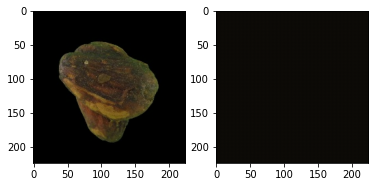

In [42]:
for img in train_ds.take(1):
    image = img
    break

result = model.predict(image, batch_size=None)

# print(np.shape(result))
image = np.asarray(image[0], dtype="uint8")
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
result = np.asarray(result[0], dtype="uint8")
plt.imshow(result)
